In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


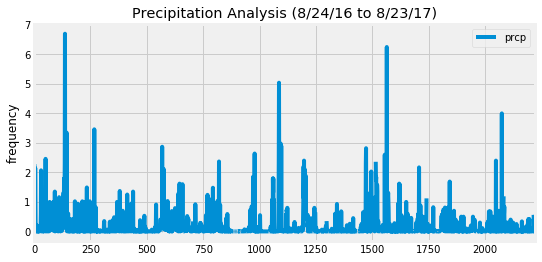

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

# Sort the dataframe by date
prcp_data_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by(func.count(Measurement.station).desc()).limit(1)[0][0]
most_active

temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

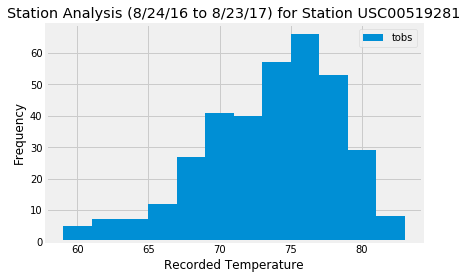

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
t_results = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active).\
                filter(Measurement.date >= one_year_ago).all()
tobs_df = pd.DataFrame(t_results)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

plt.hist(tobs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active)
plt.legend(["tobs"])
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2012-02-28', '2012-03-05')
trip_results

[(62.0, 69.57142857142857, 74.0)]

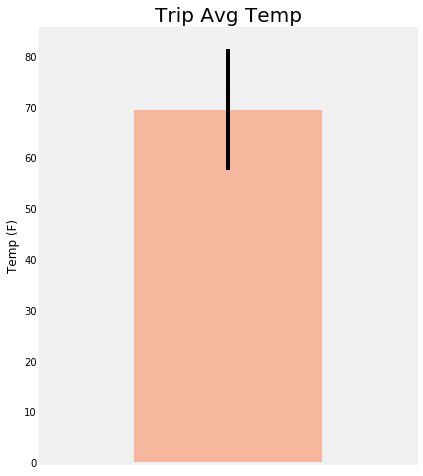

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df = pd.DataFrame(trip_results, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.savefig("Output/TripTempSummary.png")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


tripStartDate = '2012-02-28'
tripEndDate = '2012-03-05'

sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= tripStartDate)
                   .filter(Measurement.date <= tripEndDate)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

stationRainTable = pd.DataFrame(np.array(stationRain))
    
stationRainTable = stationRainTable.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

stationRainTable


,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",11.08,21.45167,-157.84888999999998,32.9
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",10.32,21.3331,-157.8025,152.4
2,USC00513117,"KANEOHE 838.1, HI US",5.79,21.4234,-157.8015,14.6
3,USC00518838,"UPPER WAHIAWA 874.3, HI US",3.8400000000000003,21.4992,-158.0111,306.6
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2.92,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",1.1800000000000002,21.2716,-157.8168,3.0
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.76,21.3152,-157.9992,0.9
7,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.03,21.5213,-157.8374,7.0
8,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-14'
end_date ='2017-07-21'

# Use the start and end date to create a range of dates
trip_dates = [x[0] for x in dates]
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

# Stip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-01 to 07-14")
daily_normals

Aggregate Daily Normals for 07-01 to 07-14


[(61.0, 76.2280701754386, 82.0),
 (68.0, 76.2542372881356, 82.0),
 (70.0, 76.34482758620689, 83.0),
 (70.0, 76.30188679245283, 83.0),
 (72.0, 76.63793103448276, 83.0),
 (68.0, 75.89090909090909, 83.0),
 (69.0, 75.46296296296296, 82.0),
 (69.0, 76.9245283018868, 83.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

daily_normals_df['date']= trip_dates

daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-14,61.0,76.228070,82.0
2017-07-15,68.0,76.254237,82.0
2017-07-16,70.0,76.344828,83.0
2017-07-17,70.0,76.301887,83.0
2017-07-18,72.0,76.637931,83.0
2017-07-19,68.0,75.890909,83.0
2017-07-20,69.0,75.462963,82.0
2017-07-21,69.0,76.924528,83.0


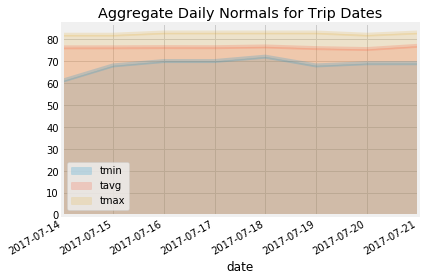

In [25]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Output/DailyNormals.png")
plt.show()